In [1]:
import numpy as np
import matplotlib.pyplot as plt
from robust_utils import generate_normal, plot, Logistic_regression, draw_boundary, sigmoid
from tqdm import tqdm
%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = (12, 8)

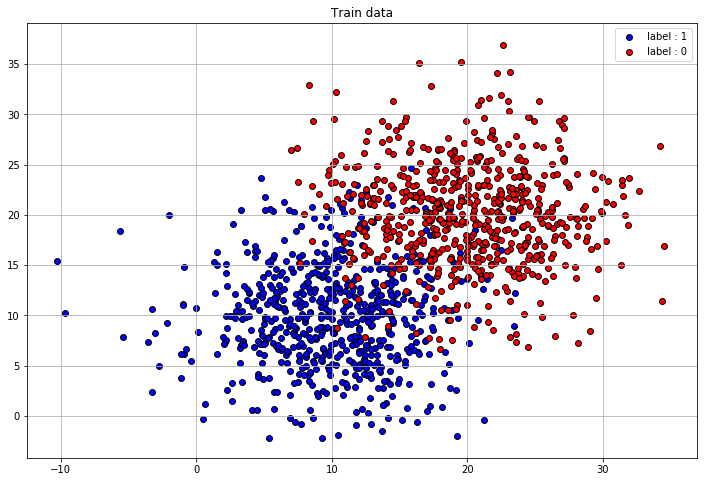

In [7]:
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = generate_normal(n_samples=2000, val_portion=0.2)
plot(X_train, Y_train)

In [8]:
def simple_poison(X, Y, poison_rate):
    '''
    Poison "n_of_poison" number of data points by flipping their labels 
    
    Returns:
    X_poison_train, Y_poison_train
    '''
    
    n_of_poison = int((X.shape[1] // 2) * poison_rate)
    Y_copy = np.copy(Y)
    Y_copy[-n_of_poison:] = 1 - Y_copy[-n_of_poison:]

    return X, Y_copy

def concat_train_val(X_train, Y_train, X_val, Y_val):
    return np.concatenate((X_val, X_train), axis=1), np.concatenate((Y_val, Y_train))

def Normalize(data):
    return (data - data.mean()) / data.std()

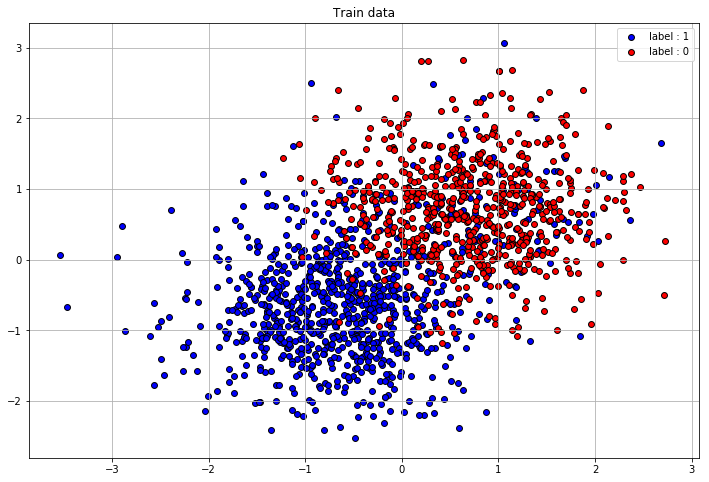

In [9]:
X_train, Y_train_poison = simple_poison(X_train, Y_train, 0.2)
X_train, Y_train_poison = concat_train_val(X_train, Y_train_poison, X_val, Y_val)
X_train = Normalize(X_train)
plot(X_train, Y_train_poison)

100%|██████████| 5000/5000 [00:00<00:00, 6516.63it/s]


train accuracy: 84.3125 %
test accuracy: 50.0 %


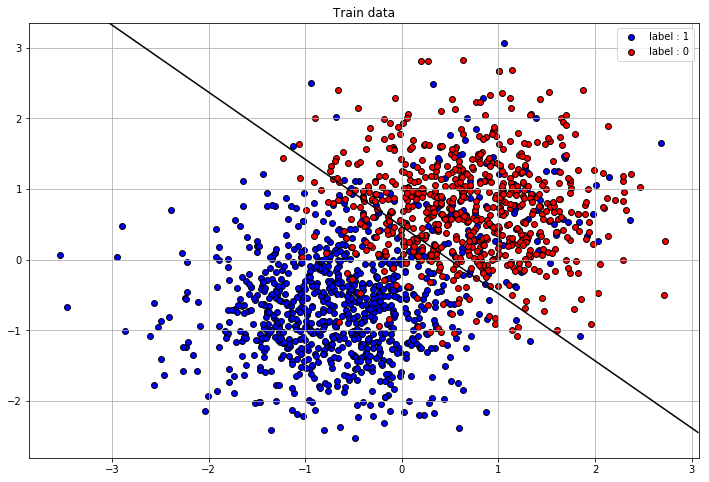

In [10]:
d = Logistic_regression(X_train, Y_train_poison, X_test, Y_test, learning_rate=0.01, num_iterations=5000)
draw_boundary(d['w'], d['b'], X_train, Y_train_poison)

In [11]:
poison_rate = np.linspace(0.3, 0.9, 10)
accuracies = []
for pr in poison_rate:
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = generate_normal(n_samples=2000, val_portion=0.125)
    X_train, Y_train_poison = simple_poison(X_train, Y_train, pr)
    X_train, Y_train_poison = concat_train_val(X_train, Y_train_poison, X_val, Y_val)
    X_train, X_val, X_test = Normalize(X_train), Normalize(X_val), Normalize(X_test)
    d = Logistic_regression(X_train, Y_train_poison, X_test, Y_test, learning_rate=0.01, num_iterations=5000)
    accuracies.append(d['test_acc'])
    print(d['w'], d['b'])

 14%|█▍        | 705/5000 [00:00<00:00, 7046.70it/s]

train accuracy: 78.9375 %
test accuracy: 85.0 %
[[-1.08423932]
 [-1.12401433]] 0.9193409897948149


 14%|█▍        | 699/5000 [00:00<00:00, 6984.41it/s]

train accuracy: 75.875 %
test accuracy: 80.75 %
[[-0.98574556]
 [-1.02617511]] 1.058340277701391


  9%|▊         | 428/5000 [00:00<00:01, 3948.33it/s]

train accuracy: 74.6875 %
test accuracy: 76.5 %
[[-0.92158771]
 [-0.94881717]] 1.2070379435780976


 14%|█▎        | 680/5000 [00:00<00:00, 6796.60it/s]

train accuracy: 74.375 %
test accuracy: 72.75 %
[[-0.84550838]
 [-0.87291234]] 1.3447800010145279


 14%|█▍        | 699/5000 [00:00<00:00, 6983.46it/s]

train accuracy: 74.75 %
test accuracy: 67.5 %
[[-0.75165172]
 [-0.83941276]] 1.4857194104373113


 14%|█▍        | 723/5000 [00:00<00:00, 7225.67it/s]

train accuracy: 77.0 %
test accuracy: 60.5 %
[[-0.65979381]
 [-0.81173907]] 1.636190091802842


 14%|█▍        | 716/5000 [00:00<00:00, 7158.03it/s]

train accuracy: 79.5625 %
test accuracy: 57.0 %
[[-0.63763459]
 [-0.73090954]] 1.798426745956228


 14%|█▎        | 684/5000 [00:00<00:00, 6832.38it/s]

train accuracy: 82.5625 %
test accuracy: 53.5 %
[[-0.62421812]
 [-0.66977953]] 1.982683911672169


 15%|█▍        | 728/5000 [00:00<00:00, 7276.54it/s]

train accuracy: 86.0625 %
test accuracy: 52.0 %
[[-0.60506385]
 [-0.6508066 ]] 2.211775933206572


100%|██████████| 5000/5000 [00:00<00:00, 6515.72it/s]

train accuracy: 89.3125 %
test accuracy: 50.25 %
[[-0.58231088]
 [-0.61040097]] 2.460211768341344


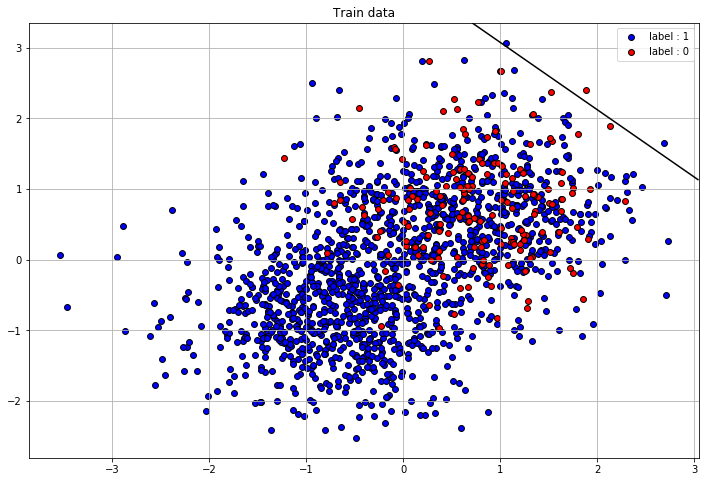

In [12]:
draw_boundary(d['w'], d['b'], X_train, Y_train_poison)

Text(0,0.5,'test accuracy')

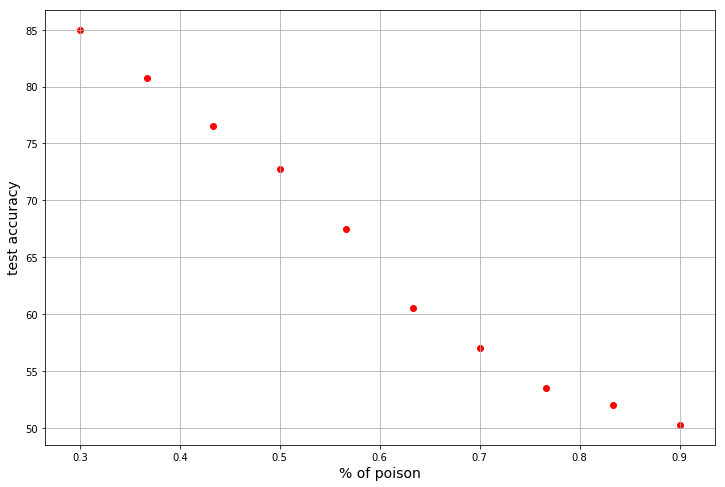

In [13]:
plt.scatter(poison_rate, accuracies, color='r')
plt.grid(True)
plt.xlabel('% of poison', fontsize=14)
plt.ylabel('test accuracy', fontsize=14)

In [14]:
def initialize_weights(dim):
    np.random.seed(0)
    
    w = np.random.randn(dim, 1)
    b = np.random.randn(1).item()

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

def forward(w, b, X_train, Y_train, X_val, Y_val):
    
    eps = 1e-8
    Yhat_t = sigmoid(np.dot(w.T, X_train) + b)
    Yhat_v = sigmoid(np.dot(w.T, X_val) + b)
    
    return Yhat_t, Yhat_v

def backward_eps(w, b, X_train, Y_train, X_val, Y_val, Yhat_t, Yhat_v):
    
    eps_g = - 0.001 * (Yhat_t - Y_train).T * X_train.T@X_val@(Yhat_v - Y_val).T
    mu_tilde = np.maximum(0, -eps_g)
    if np.sum(mu_tilde) == 0:
        return mu_tilde
    return mu_tilde / np.sum(mu_tilde)
    

def backward_params(w, b, mu, X, Y, Yhat):

    dw = np.dot(X, mu * ((Yhat - Y).T))
    db = np.dot((Yhat - Y), mu)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads

def fit(w, b, X_train, Y_train, X_val, Y_val, num_iterations, learning_rate, print_cost=False):
    
    costs = []
    batch_size = X_val.shape[1]
    
    for i in tqdm(range(num_iterations)):
        Yhat_t, Yhat_v = forward(w, b, X_train, Y_train, X_val, Y_val)
        mu = backward_eps(w, b, X_train, Y_train, X_val, Y_val, Yhat_t, Yhat_v)
        grads = backward_params(w, b, mu, X_train, Y_train, Yhat_t)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw  
        b = b - learning_rate * db
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs


def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    assert(w.shape[0] == X.shape[0])
    
    ### START CODE HERE ### (≈ 4 line of code)
    Yhat = sigmoid(np.dot(w.T, X) + b)
    Yhat[Yhat > 0.5] = 1
    Yhat[Yhat <= 0.5] = 0
    Y_prediction = Yhat
    ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

# GRADED FUNCTION: model

def robust_train(X_train, Y_train, X_val, Y_val, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_weights(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = fit(w, b, X_train, Y_train, X_val, Y_val, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    ### END CODE HERE ###

    # Print train/test Errors
    train_acc = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_acc = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    print("train accuracy: {} %".format(train_acc))
    print("test accuracy: {} %".format(test_acc))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
         "train_acc":train_acc,
         "test_acc":test_acc}
    
    return d

In [15]:
poison_rate = np.linspace(0.3, 0.9, 10)
accuracies_l2w = []
for pr in poison_rate:
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = generate_normal(n_samples=2000, val_portion=0.125)
    X_train, Y_train_poison = simple_poison(X_train, Y_train, pr)
    X_train, Y_train_poison = concat_train_val(X_train, Y_train_poison, X_val, Y_val)
    X_train, X_val, X_test = Normalize(X_train), Normalize(X_val), Normalize(X_test)
    d = robust_train(X_train, Y_train_poison, X_val, Y_val, X_test, Y_test, learning_rate=0.001, num_iterations=5000)
    accuracies_l2w.append(d['test_acc'])
    print(d['w'], d['b'])

  0%|          | 11/5000 [00:00<01:03, 78.90it/s]

train accuracy: 81.1875 %
test accuracy: 90.75 %
[[-0.7509168]
 [-1.142089 ]] [[0.26886132]]


  1%|          | 41/5000 [00:00<00:12, 397.38it/s]

train accuracy: 78.5625 %
test accuracy: 90.5 %
[[-0.75035409]
 [-1.14310157]] [[0.30133989]]


  0%|          | 14/5000 [00:00<00:37, 132.95it/s]

train accuracy: 76.5 %
test accuracy: 90.25 %
[[-0.75007566]
 [-1.14489656]] [[0.33774456]]


  0%|          | 7/5000 [00:00<01:35, 52.53it/s]

train accuracy: 74.3125 %
test accuracy: 89.75 %
[[-0.73956202]
 [-1.14604656]] [[0.38022431]]


  1%|▏         | 68/5000 [00:00<00:08, 590.17it/s]

train accuracy: 72.6875 %
test accuracy: 89.75 %
[[-0.72805793]
 [-1.15127052]] [[0.42624607]]


  1%|▏         | 66/5000 [00:00<00:08, 577.46it/s]

train accuracy: 70.8125 %
test accuracy: 89.25 %
[[-0.70083414]
 [-1.16550223]] [[0.48669488]]


  0%|          | 2/5000 [00:00<06:46, 12.28it/s]

train accuracy: 69.0 %
test accuracy: 88.0 %
[[-0.69516611]
 [-1.16216937]] [[0.5434498]]


  0%|          | 8/5000 [00:00<01:04, 77.35it/s]

train accuracy: 68.0625 %
test accuracy: 88.0 %
[[-0.69238257]
 [-1.14926761]] [[0.60555559]]


  1%|          | 55/5000 [00:00<00:08, 549.80it/s]

train accuracy: 67.5625 %
test accuracy: 85.75 %
[[-0.68363078]
 [-1.13650596]] [[0.67520927]]


100%|██████████| 5000/5000 [00:22<00:00, 221.27it/s]

train accuracy: 68.1875 %
test accuracy: 84.25 %
[[-0.66869817]
 [-1.12677784]] [[0.76896479]]


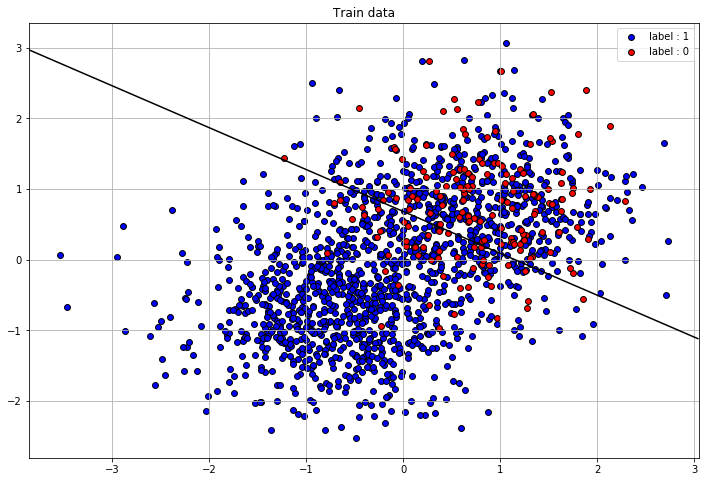

In [16]:
draw_boundary(d['w'], d['b'], X_train, Y_train_poison)

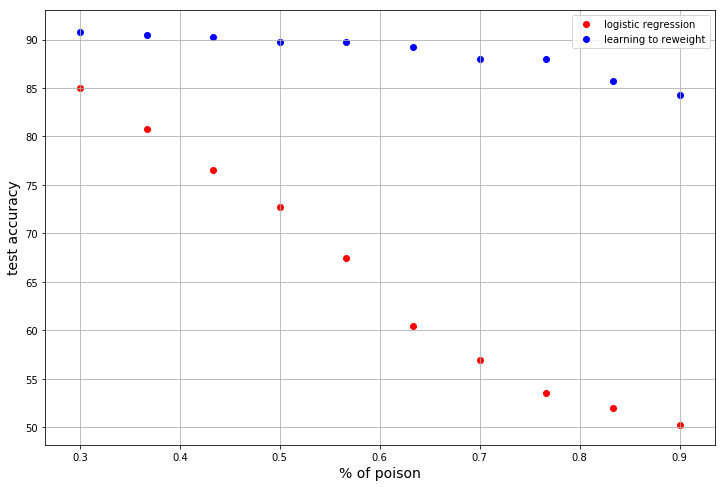

In [17]:
plt.scatter(poison_rate, accuracies, color='r', label = 'logistic regression')
plt.scatter(poison_rate, accuracies_l2w, color='b', label = 'learning to reweight')
plt.grid(True)
plt.xlabel('% of poison', fontsize=14)
plt.ylabel('test accuracy', fontsize=14)
plt.legend()